1. Train `model_5` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
  * [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the model's best weights only.

  * [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the model from training once the validation loss has stopped improving for ~3 epochs.


2. Checkout the [Keras guide on using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/). Can you get this working with one of our models?
  *   Hint: You'll want to incorporate it with a custom token [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

  *  It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.


3. Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert](https://tfhub.dev/google/experts/bert/pubmed/2) (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
  *  Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the [TensorFlow Hub guide](https://tfhub.dev/google/experts/bert/pubmed/2)).
  
  *  Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf

4. What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
   *  Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.
        

5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
   *  `PREDICTED_LABEL`: `SEQUENCE`
  
   *  `PREDICTED_LABEL`: `SEQUENCE`
  
   *  `PREDICTED_LABEL`: `SEQUENCE`
  
   *  `PREDICTED_LABEL`: `SEQUENCE`
  
   *  ...

In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0 tensorflow_text

INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
   

## Downloading the data and preprocessing it.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
tf.__version__

'2.15.0'

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 15.47 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [5]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename) # Get all lines from filename
    abstract_lines = "" # Create an empty abstract
    abstract_samples = [] # Create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # Check to see if there is an ID line
            abstract_id = line
            abstract_lines = "" # Reset the abstract string if the line is an ID line
        elif line.isspace(): # Check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines() # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # Create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # Split target label from the text
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data) # Add line data to abstract samples list
        else:
            abstract_lines += line

    return abstract_samples

In [9]:
%%time
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # Validation data
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 568 ms, sys: 133 ms, total: 701 ms
Wall time: 764 ms


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [13]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [14]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # We want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

In [15]:
train_df["target"].to_numpy()

array(['OBJECTIVE', 'METHODS', 'METHODS', ..., 'RESULTS', 'CONCLUSIONS',
       'CONCLUSIONS'], dtype=object)

In [16]:
train_df["target"].to_numpy().reshape(-1, 1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Creating a series of model experiments

We've preprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments

### 1. Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?

In [19]:
# Loading the pre-trained embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-01-28 11:16:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-28 11:16:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-28 11:16:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
# Getting the path of the glove embedding (using 100D)
import numpy as np
glove_path = 'glove.6B.100d.txt'

embedding_index = {}

# Making dict of vector representtion of the words (s --> [8, 48......])
with open(glove_path) as f:
  for line in f:

    # Getting the words and coef in a variable
    word , coefs = line.split(maxsplit = 1)
    coefs = np.fromstring(coefs , 'f' , sep = ' ')

    # Adding the coefs to our embedding dict
    embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

Found 400000 word vectors


In [21]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [22]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

In [23]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [24]:
# Creatinga a text vectorizaiton layer (68k vocab size from the paper itself)
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens= 68000 ,
                                    output_sequence_length = 56)

# Adapt our text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [25]:
# Getting the vocabulary of the vectorizer
text_vocab = text_vectorizer.get_vocabulary()
len(text_vocab)

64841

In [26]:
# Getting the dict mapping word ---> index
word_index_text = dict(zip(text_vocab, range(len(text_vocab))))

In [27]:
# Creating a function that will give us a embedding matrix
def get_glove_embedding_matrix(num_tokens, embedding_dim, word_index):
    # Defining the hits and misses here
    hits, misses = 0, 0

    # Prepare the embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    return embedding_matrix, hits, misses

In [28]:
# Length of embedding dim
len(embedding_index.get('a'))

100

In [29]:
# Using the above function to get the embedding matrix
num_tokens_text = len(text_vocab) + 2
embedding_dim = 100

In [30]:
sentence_embed_matrix, hits_, misses_ = get_glove_embedding_matrix(num_tokens=num_tokens_text, embedding_dim=embedding_dim, word_index=word_index_text)

In [31]:
print(f'Hits: {hits_} and Misses: {misses_} for the sentence embedding matrix')

Hits: 29730 and Misses: 35111 for the sentence embedding matrix


In [32]:
# Adding the embedding matrix to our embedding layer
from tensorflow.keras.layers import Embedding

sentence_embeded_layer = Embedding(num_tokens_text,
                                   embedding_dim,
                                   embeddings_initializer = tf.keras.initializers.Constant(sentence_embed_matrix),
                                   trainable=False)

In [33]:
# Creating the datasets for our both sentences and chars

train_sentences_vectors = text_vectorizer(np.array([[sen] for sen in train_sentences])).numpy()
val_sentences_vectors = text_vectorizer(np.array([[sen] for sen in val_sentences])).numpy()

train_ds = tf.data.Dataset.from_tensor_slices((train_sentences_vectors, train_labels_encoded))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

validation_ds = tf.data.Dataset.from_tensor_slices((val_sentences_vectors, val_labels_encoded))
validation_ds = validation_ds.batch(32).prefetch(tf.data.AUTOTUNE)

train_ds, validation_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 56), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [34]:
input = layers.Input(shape = (None,) , dtype = 'int64')
glove_emb = sentence_embeded_layer(input)
x = layers.Conv1D(128 , 5 , activation= 'relu' , padding = 'same')(glove_emb)
x = layers.MaxPooling1D(5, padding = 'same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.MaxPooling1D(5 , padding ='same')(x)
x = layers.Conv1D(128, 5, activation="relu" , padding = 'same')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names) , activation= 'softmax')(x)

glove_model = tf.keras.Model(input , output)
glove_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         6484300   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

In [35]:
# Compiling and fitting the model
glove_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ['accuracy'])

glove_model.fit(train_ds,
                 epochs = 3 ,
                 validation_data = validation_ds)

Epoch 1/3
5627/5627 [==============================] - 49s 8ms/step - loss: 0.6520 - accuracy: 0.7566 - val_loss: 0.5488 - val_accuracy: 0.7945
Epoch 2/3
5627/5627 [==============================] - 37s 7ms/step - loss: 0.5279 - accuracy: 0.8081 - val_loss: 0.5109 - val_accuracy: 0.8113
Epoch 3/3
5627/5627 [==============================] - 32s 6ms/step - loss: 0.4840 - accuracy: 0.8242 - val_loss: 0.5361 - val_accuracy: 0.8084


## Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained  embedding for the [TensorFlow Hub BERT PubMed expert] (a language model pretrained on PubMed texts) pretrained embedding.

In [36]:
# Loading in the both encoder and the preprocessing models
import tensorflow_text as text
import tensorflow_hub as hub


preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3' ,
                                     trainable = False , name = 'pubmed_bert_preprocessor')

bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2' ,
                            trainable = False ,
                            name = 'bert_model_layer')

In [37]:
input = layers.Input(shape = [], dtype=tf.string, name="input_sentences")
bert_inputs=preprocessing_layer(input)
bert_embedding=bert_layer(bert_inputs)
print(f"Bert embedding shape: {bert_embedding}")
x=layers.Dense(128, activation="relu")(bert_embedding['pooled_output'])
x = layers.Dropout(0.5)(x)
output=layers.Dense(len(class_names), activation="softmax")(x)

pubmed_bert_model = tf.keras.Model(input, output)
pubmed_bert_model.summary()

Bert embedding shape: {'pooled_output': <KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'sequence_output': <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, 'encoder_outputs': [<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'bert_model_layer')>, <KerasTensor: sh

In [38]:
# Making datasets for the pubmed model

train_sen_ds = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_encoded))
train_sen_ds = train_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_sen_ds = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_encoded))
val_sen_ds = val_sen_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
pubmed_bert_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() ,
                          optimizer = tf.keras.optimizers.Adam(),
                          metrics =['accuracy'])

pubmed_bert_model.fit(train_sen_ds ,
                      steps_per_epoch = int(0.1 * len(train_sen_ds)),
                      epochs = 3 ,
                      validation_data = val_sen_ds ,
                      validation_steps = int(0.1 * len(val_sen_ds)))

Epoch 1/3
562/562 [==============================] - 251s 420ms/step - loss: 0.6586 - accuracy: 0.7749 - val_loss: 0.4581 - val_accuracy: 0.8391
Epoch 2/3
562/562 [==============================] - 239s 425ms/step - loss: 0.5150 - accuracy: 0.8225 - val_loss: 0.4363 - val_accuracy: 0.8348
Epoch 3/3
562/562 [==============================] - 239s 426ms/step - loss: 0.4988 - accuracy: 0.8280 - val_loss: 0.4144 - val_accuracy: 0.8577


## What happens if you were to merge our `line_number` and `total_lines` features for each sequence? For example, created a `X_of_Y` feature instead? Does this effect model performance?
   *  Another example: `line_number=1` and `total_lines=11` turns into `line_of_X=1_of_11`.

In [40]:
# Combining the total lines and line number into a new feature!
train_df['line_number_total'] = train_df['line_number'].astype(str) + '_of_' + train_df['total_lines'].astype(str)
val_df['line_number_total'] = val_df['line_number'].astype(str) + '_of_' + val_df['total_lines'].astype(str)

train_df.head(10)

,target,text,line_number,total_lines,line_number_total
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11,0_of_11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11,1_of_11
2,METHODS,outcome measures included pain reduction and i...,2,11,2_of_11
3,METHODS,pain was assessed using the visual analog pain...,3,11,3_of_11
4,METHODS,secondary outcome measures included the wester...,4,11,4_of_11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11,5_of_11
6,RESULTS,there was a clinically relevant reduction in t...,6,11,6_of_11
7,RESULTS,the mean difference between treatment arms ( @...,7,11,7_of_11
8,RESULTS,"further , there was a clinically relevant redu...",8,11,8_of_11
9,RESULTS,these differences remained significant at @ we...,9,11,9_of_11


In [41]:
# Perform one hot encoding on the train and transform the validation dataframe
from sklearn.preprocessing import OneHotEncoder

# Creating an instance
one_hot_encoder = OneHotEncoder()

# Fitting on the training dataframe
one_hot_encoder.fit(np.expand_dims(train_df['line_number_total'] , axis = 1))

# Transforming both train and val df
train_line_number_total_encoded = one_hot_encoder.transform(np.expand_dims(train_df['line_number_total'] , axis =1))
val_line_number_total_encoded  = one_hot_encoder.transform(np.expand_dims(val_df['line_number_total'] , axis= 1))

# Checking the shapes
train_line_number_total_encoded.shape , val_line_number_total_encoded.shape

((180040, 460), (30212, 460))

In [42]:
# Converting the sparse object to array
train_line_number_total_encoded = train_line_number_total_encoded.toarray()
val_line_number_total_encoded = val_line_number_total_encoded.toarray()

# Converting the datatype to int
train_line_number_total_encoded = tf.cast(train_line_number_total_encoded , dtype= tf.int32)
val_line_number_total_encoded = tf.cast(val_line_number_total_encoded , dtype= tf.int32)

In [43]:
# Making the performant datasets for our tribid model
train_data = tf.data.Dataset.from_tensor_slices((train_sentences ,
                                                 train_chars ,
                                                 train_line_number_total_encoded))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_encoded)

val_data = tf.data.Dataset.from_tensor_slices((val_sentences ,
                                               val_chars ,
                                               val_line_number_total_encoded))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_encoded)

# Zipping the data and labels
train_dataset = tf.data.Dataset.zip((train_data , train_labels))
val_dataset = tf.data.Dataset.zip((val_data , val_labels))

# Applying batch and prefetching
train_dataset = train_dataset.batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

train_dataset , val_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 460), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [44]:
# Buidling the tribid model using the functional api

input_token=layers.Input(shape = [] , dtype =tf.string)
bert_inputs_token=preprocessing_layer(input_token)
bert_embedding_sentence=bert_layer(bert_inputs_token)
output_token_sentence=layers.Dense(64 , activation = 'relu')(bert_embedding_sentence['pooled_output'])
token_model = tf.keras.Model(input_token , output_token_sentence)

input_char = layers.Input(shape = [] , dtype =tf.string)
bert_inputs_char = preprocessing_layer(input_char)
bert_embedding_char = bert_layer(bert_inputs_char)
output_char = layers.Dense(64 , activation = 'relu')(bert_embedding_char['pooled_output'])
char_model = tf.keras.Model(input_char , output_char)

line_number_total_input = layers.Input(shape = (460,), dtype = tf.int32)
dense = layers.Dense(32 , activation = 'relu')(line_number_total_input)
total_line_number_model = tf.keras.Model(line_number_total_input , dense)

# Concatenating the tokens amd chars output (Hybrid!!!)
combined_embeddings = layers.Concatenate(name = 'token_char_hybrid_embedding')([token_model.output ,
                                                                                char_model.output])

# Combining the line_number_total to our hybrid model (Time for Tribid!!)
z = layers.Concatenate(name = 'tribid_embeddings')([total_line_number_model.output ,
                                                    combined_embeddings])

# Adding a dense + dropout and creating our output layer
dropout = layers.Dropout(0.5)(z)
x = layers.Dense(128 , activation='relu')(dropout)
output_layer = layers.Dense(5 , activation='softmax')(x)

# Packing into a model
tribid_model = tf.keras.Model(inputs = [token_model.input ,
                                        char_model.input ,
                                        total_line_number_model.input] ,
                              outputs = output_layer)

tribid_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 pubmed_bert_preprocessor (  {'input_type_ids': (None,    0         ['input_2[0][0]',             
 KerasLayer)                 128),                                   'input_3[0][0]']             
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                     

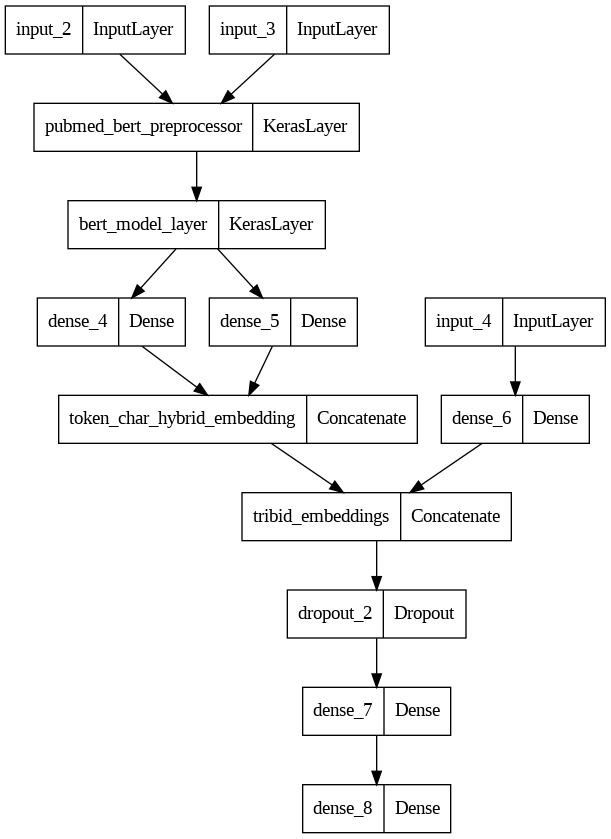

In [45]:
# Plotting the model structure
from tensorflow.keras.utils import plot_model
plot_model(tribid_model)

In [46]:
tribid_model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                     optimizer= tf.keras.optimizers.Adam() ,
                     metrics = ['accuracy'])

tribid_model.fit(train_dataset ,
                 steps_per_epoch = int(0.1 * len(train_dataset)),
                 epochs = 3 ,
                 validation_steps = int(0.1 * len(val_dataset)),
                 validation_data = val_dataset)

Epoch 1/3
281/281 [==============================] - 519s 2s/step - loss: 0.7045 - accuracy: 0.7477 - val_loss: 0.4283 - val_accuracy: 0.8504
Epoch 2/3
281/281 [==============================] - 505s 2s/step - loss: 0.4516 - accuracy: 0.8465 - val_loss: 0.3501 - val_accuracy: 0.8780
Epoch 3/3
281/281 [==============================] - 514s 2s/step - loss: 0.4014 - accuracy: 0.8569 - val_loss: 0.3191 - val_accuracy: 0.8896


In [47]:
# Evaluating on the whole val data
tribid_model.evaluate(val_dataset)

473/473 [==============================] - 725s 2s/step - loss: 0.3086 - accuracy: 0.8906


[0.30858784914016724, 0.890573263168335]

## 4. Train model_5 on all of the data in the training dataset for as many epochs until it stops improving.

In [48]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=30)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=30)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=30)

# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=30)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=30)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=30)

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_line_numbers_one_hot.shape


(TensorShape([180040, 30]), TensorShape([180040, 30]))

In [49]:
# Re-building the Model 5

# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)


# 2. Char inputs
char_inputs = layers.Input(shape= [], dtype="string", name="char_inputs")
char_embeddings = tf_hub_embedding_layer(char_inputs)
exp_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(char_embeddings)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(exp_layer)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(30,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(30,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)



# Summary of the model
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_inputs (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]',        
  (KerasLayer)                                            24         'char_inputs[0][0]']         
                                                                                                  
 lambda (Lambda)             (None, 1, 512)               0         ['universal_sentence_en

In [50]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

`tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only.

`tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [51]:
# Creating the callbacks
check_filepath = 'best_weights/checkpoint.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= check_filepath ,
                                                               save_weights_only = True ,
                                                               save_best_only = True  ,
                                                               save_freq = 'epoch' ,
                                                               monitor = 'val_loss')


## These callbacks together improve training efficiency and help the model achieve better generalization.

# Training stops once the validation loss plateaus (does not improve by at least min_delta) for patience epochs.
early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' ,
                                                   patience = 5, min_delta = 0.3 , verbose = 1)

# Reduces the learning rate when validation loss stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # Reduces the learning rate by a factor of 0.2 (i.e., multiplies the learning rate by 0.2)
                                                 patience=2, # Waits for 2 consecutive epochs of no improvement in validation loss before reducing the learning rate
                                                 verbose=1,
                                                 min_lr=1e-7)

In [52]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) ,
                    optimizer = tf.keras.optimizers.Adam() ,
                metrics = ['accuracy'])

history = model_5.fit(train_pos_char_token_dataset ,
                      epochs = 50 ,
                      validation_data = val_pos_char_token_dataset  ,
                      callbacks = [early_stopping , model_checkpoint_callback ,
                                   reduce_lr])

Epoch 1/50
5627/5627 [==============================] - 283s 48ms/step - loss: 0.9675 - accuracy: 0.8162 - val_loss: 0.9234 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 2/50
5627/5627 [==============================] - 248s 44ms/step - loss: 0.9296 - accuracy: 0.8454 - val_loss: 0.9136 - val_accuracy: 0.8518 - lr: 0.0010
Epoch 3/50
5627/5627 [==============================] - 250s 44ms/step - loss: 0.9219 - accuracy: 0.8514 - val_loss: 0.9102 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 4/50
5627/5627 [==============================] - 241s 43ms/step - loss: 0.9167 - accuracy: 0.8554 - val_loss: 0.9054 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 5/50
5627/5627 [==============================] - 229s 41ms/step - loss: 0.9123 - accuracy: 0.8585 - val_loss: 0.9055 - val_accuracy: 0.8569 - lr: 0.0010
Epoch 6/50
5627/5627 [==============================] - 238s 42ms/step - loss: 0.9097 - accuracy: 0.8602 - val_loss: 0.9037 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 6: early stopping


## Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:

 * PREDICTED_LABEL: SEQUENCE

 * PREDICTED_LABEL: SEQUENCE

 * PREDICTED_LABEL: SEQUENCE

 * PREDICTED_LABEL: SEQUENCE

In [53]:
from spacy.lang.en import English

def preprocess_abstracts_sequences(example_abstracts, model):
  abstracts = pd.DataFrame(example_abstracts)

  nlp = English()

  # New version of spaCy
  sentencizer = nlp.add_pipe("sentencizer") # Create sentence splitting pipeline object

  # Create "doc" of parsed sequences, change index for a different abstract
  doc = nlp(example_abstracts[0]["abstract"])
  abstract_lines = [str(sent) for sent in list(doc.sents)] # Return detected sentences from doc in string type (not spaCy token type)

  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)


  # Get all line_number value from sample abstract
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=30)


  # Get all total_lines values from sample abstract
  test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
  # One-hot encode to same depth as training data, so model accepts right input shape
  test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=30)

  # Split abstract lines into characters
  abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

  test_abstract_pred_probs = model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

  # Turn prediction probabilities into prediction classes
  test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

  # Turn prediction class integers into string class names
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

  # Visualize abstract lines and predicted sequence labels
  for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

In [54]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2025-01-28 12:44:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2025-01-28 12:44:11 (76.3 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [55]:
preprocess_abstracts_sequences(example_abstracts, model_5)

1/1 [==============================] - 4s 4s/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored th